In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Ejercicio 11 del Capitulo 2 del Gelman:

Supongamos mediciones independientes $y_{1},y_{2},...,y_{5}$ que siguen una [distribucion de Cauchy](https://en.wikipedia.org/wiki/Cauchy_distribution) con centro desconocido $\theta$ y escala conocida $1$.

$p(y_{i}|\theta) \propto \frac{1}{1 + (y_{i} − \theta)^{2}}$

Asumimos por simplicidad que el prior es una distribucion uniforme en [0,100].

Si observamos ($y_{1},..., y_{5}$) = (43, 44, 45, 46.5, 47.5):

1.   Calcule la distribucion posterior no normalizada $p(y|\theta)p(\theta)$ en una grilla de puntos $\theta = 0, \frac{1}{m},\frac{2}{m},...,100$ para algun entero $m$ grande. Utilizando esta aproximacion numerica, calcule y grafique la posterior normalizada $p(\theta|y)$ como funcion de $\theta$.
2.   Samplee 1000 muestras de $\theta$ de la distribución posterior y haga un histograma de las muestras.
3.   Use las 1000 muestras de $\theta$ para obtener 1000 muestras de $y_{6}$ utilizando la posterior predictiva, y haga un histograma.

_Nico_: a mi me sirvió leer esto para entrar en tema:

* https://statswithr.github.io/book/the-basics-of-bayesian-statistics.html



# Resolucion

## Punto 1

Inicialicemos las mediciones:

In [15]:
# "y" es un array que contiene los valores de las 5 mediciones del problema
y=np.asarray([43,44,45,46.5,47.5])

# Revisamos el contenido y las dimensiones del array:
print(y)
print(y.shape)

[43.  44.  45.  46.5 47.5]
(5,)


Y los valores posibles de $\theta$, generamos 3000 en el espacio de 0 a 100:

In [7]:
# "theta_vals" contiene los valores posibles de tita, sobre los que vamos a calcular cosas
theta_vals=np.linspace(0.0,100.0,3000)
print(theta_vals[0],theta_vals[-1])

0.0 100.0


Para cada $\theta$, la verosimilitud se calcula como:

$p(y|\theta)=\prod_{i=1}^{5}p(y_{i}|\theta)$

Numericamente, es mas estable calcular el logaritmo de la probabilidad:

$\text{ln }p(y|\theta)=\sum_{i=1}^{5}\text{ln }p(y_{i}|\theta)$

> Nico: esto es porque la productoria (porque multiplica cosas) puede generar números demasiado chicos que se convierten en cero (por underflow) y supongo que pasa también para los grandes (por overflow).

In [8]:
from scipy.stats import cauchy

In [20]:
# Para consultar sobre el módulo y sus métodos, correr:
# cauchy?

In [13]:
print("Prob para theta=0:", np.prod(cauchy(loc=theta_vals[0]).pdf(y)))
print("Prob para theta=0:", np.exp(np.sum(cauchy(loc=theta_vals[0]).logpdf(y))))

Prob para theta=0: 9.217719162911935e-20
Prob para theta=0: 9.217719162911966e-20


Vamos a descomponer estas dos líneas, y revisarlas paso a paso.

> Nico: primero, `cauchy(loc=loc).pdf(x)` devuelve el valor de la PDF (con parametro de "location" igual al `loc`) evaluada en los puntos especificados por el vector `x` (ver `cauchy?`).


In [18]:
# Revisamos las dimensiones y el contenido del array resultante
print(cauchy(loc=theta_vals[0]).pdf(y).shape)
print(cauchy(loc=theta_vals[0]).pdf(y))

(5,)
[0.00017206 0.00016433 0.00015711 0.00014714 0.00014102]


Pero tenemos un unico valor de $\theta$! Tenemos varios.

> Nico: _pero_ no debería sorprender a nadie, porque eso _es_ lo que hace esa función.
> 
> Ahora, a pesar de que dijimos que ibamos paso por paso, hacemos toda la cuenta de una igual. Armé una función para aclarar un poco lo que está pasando.
> 
> Para cada theta que tenemos, calcular la PDF de cauchy (directamente en ln con .logpdf).
>
> Luego sumar los valores de "log(cauchyPDF)".
> 
> Finalmente elevar la suma "sum(log(cauchyPDF))" a la "e" para volver a unidades de densidad (revertir el log que hicimos antes para simplificar todo y estabilizar la cuenta computacionalmente).

In [25]:
def verosimil(theta):
    return np.exp(
        np.sum(
                cauchy(loc=theta).logpdf(y)
            )
        )

verosimilitud=np.asarray([verosimil(theta) for theta in theta_vals])
verosimilitud.shape

(3000,)

> Nico: ahora para cada valor en "y" calcula la log(PDF) de cauchy
>
> Obs: le pasa todos los valores de tita a "loc". Supongo que por el output de shape, la función cauchy está vectorizada respecto a ese argumento.

In [26]:
verosimilitud_aux=np.asarray([cauchy(loc=theta_vals).logpdf(y_val) for y_val in y])
print(verosimilitud_aux.shape)

(5, 3000)


> Nico: ahora termina la cuenta de la verosimilitud. El argumento "axis" de np.sum debe hacer cosas por filas.
> 
> En R eso es el apply de cada día... cuánta cindor les hace falta :P

In [27]:
verosimilitud=np.exp(np.sum(verosimilitud_aux,axis=0))
print(verosimilitud.shape)

(3000,)


> Nico: entiendo que cauchy esta vectorizada respecto a "loc", y pdf esta vectorizada respecto a "x". O sea que estas dos formas de codearlo fueron equivalentes.

> Nico: plot de "verosimilitud" en función de los valores escaneados del parámetro.

Text(0.5, 0, '$\\theta$')

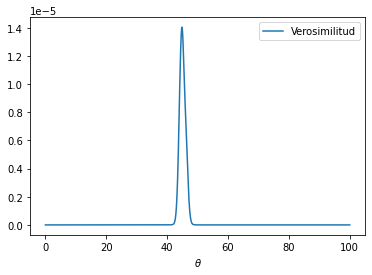

In [32]:
#plt.plot(theta_vals,prior,label='Prior')
plt.plot(theta_vals,verosimilitud,label='Verosimilitud')
plt.legend(loc='upper right')
plt.xlabel(r'$\theta$')

Y cuanto vale $p(y|\theta)p(\theta)$?

> Nico: acá definen el "prior" como una ¿densidad uniforme? está raro

$prior=\frac{1}{100-0}*[1,\ .\ .\ .,1]$

In [33]:
prior=1.0/(theta_vals[-1]-theta_vals[0])*np.ones(len(theta_vals))
print(prior.shape)
print(verosimilitud.shape)
print((prior*verosimilitud).shape)

(3000,)
(3000,)
(3000,)


> Nico: gracias por usar variables con nombre explicativo for once :)

In [35]:
posterior_no_normalizado=prior*verosimilitud

Verificamos (una vez) que esta bien

In [36]:
np.allclose(
    posterior_no_normalizado,
    np.asarray([prior[i]*verosimilitud[i] for i in range(len(verosimilitud))])
)

True

> Nico: qué será realmente "allclose"?
> 
> And now... plot de el "posterior no normalizado" vs los valores escaneados del parámetro tita.

Text(0.5, 0, '$\\theta$')

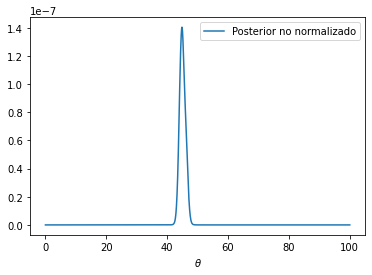

In [37]:
plt.plot(theta_vals, posterior_no_normalizado, label='Posterior no normalizado')
plt.legend(loc='upper right')
plt.xlabel(r'$\theta$')

Obviamente aca es la verosimilitud

> Nico: obviamente esa frase no tiene sentido.

Y la evidencia? Bueno, podemos calcularla numericamente

$$p(y)=\int d\theta p(y|\theta)p(\theta)\approx \sum_{j=1}^{m}\Delta_{j}p(y|\theta_{j})p(\theta_{j})$$


In [63]:
delta_j=(theta_vals[1]-theta_vals[0])
evidencia=np.sum(posterior_no_normalizado)*delta_j
print(evidencia)

3.418359031121251e-07


> Nico: no tengo idea qué es esto :) ¿evidencia?

In [64]:
delta_j=(theta_vals[1]-theta_vals[0])
posterior=posterior_no_normalizado/evidencia
print(np.sum(posterior*delta_j))

0.9999999999999999


> Nico: no tengo idea qué es esto tampoco :D quizás están chequeando que sume 1 la distribución posterior (?)

> Nico: ahora un plot con todo!

Text(0.5, 0, '$\\theta$')

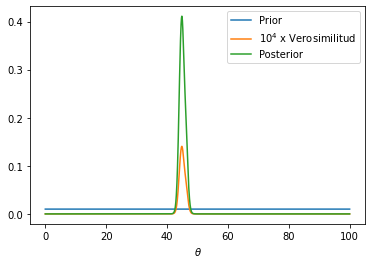

In [65]:
plt.plot(theta_vals,prior,label='Prior')
plt.plot(theta_vals,10000*verosimilitud,label='$10^{4}$ x Verosimilitud')
plt.plot(theta_vals,posterior,label='Posterior')
plt.legend(loc='upper right')
plt.xlabel(r'$\theta$')

## Punto 2

Como sampleamos una vez que tenemos la posterior numerica?

In [51]:
# np.random.choice?
# p: The probabilities associated with each entry in a.

In [66]:
delta_j=(theta_vals[1]-theta_vals[0])
theta_samples=np.random.choice(a=theta_vals, p=posterior*delta_j, size=1000)

Text(0.5, 0, '$\\theta$')

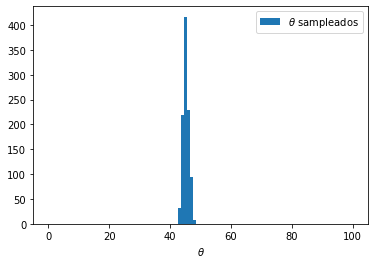

In [67]:
#bins=10
bins=np.linspace(0.0,100.0,100)
plt.hist(theta_samples,bins=bins,label=r'$\theta$ sampleados')
#plt.plot(theta_vals,len(theta_samples)*posterior,label='$N_{\t{eventos}}$ x Posterior')
plt.legend(loc='upper right')
plt.xlabel(r'$\theta$')

## Punto 3

La posterior predictiva es la probabilidad de una nueva medicion $y_{6}$ dadas todas las anteriores:

$p(y_{6}|y_{1},...,y_{5})$

Para hacer esto, una opcion muy común es plantear la posterior predictiva como una marginalización de la distribución conjunta condicional $p(y_6, \theta | \mathbf{y})$:

$$p(y_{6}|y_{1},...,y_{5})=\int d\theta p(y_{6},\theta|y_{1},...,y_{5})$$

Y usar la regla del producto:

$$\int d\theta p(y_{6},\theta|y_{1},...,y_{5})= \int d\theta p(y_{6}|\theta)p(\theta|y_{1},...,y_{5})$$

Donde asumimos que $y_{6}$ e $(y_{1},...,y_{5})$ son condicionalmente independientes dado $\theta$.

Esta integral podria hacerse numericamente de la misma manera que hicimos antes: armamos una grilla en $\theta$ y aproximamos la funcion para cada valor de $y_{6}$ usando esa grilla.

Sin embargo, Gelman nos sugiere que aprovechemos el sampleo del interior anterior. 

> Interior?

Una manera es usarlo para aproximar la integral (mucho mas eficientemente que utilizando una grilla uniforme de puntos en $\theta$) haciendo lo que se conoce como _Importance Sampling_:

$$\int d\theta f(\theta)\approx\frac{1}{N_{\text{sampleos}}}\sum_{n=1}^{N_{\text{sampleos}}}\frac{f(\theta_{n})}{p(\theta_{n})}$$

> Nico: qué es "f(tita_n)" ahí?

Donde los puntos fueron sampleados de acuerdo a $p(\theta_{i})$.

En nuestro, caso, el denominador se simplifica con una expresion del numerador y tenemos

$$\int d\theta p(y_{6}|\theta)p(\theta|y_{1},...,y_{5})\approx\frac{1}{N_{\text{sampleos}}}\sum_{n=1}^{N_{\text{sampleos}}}p(y_{6}|\theta_{n})$$


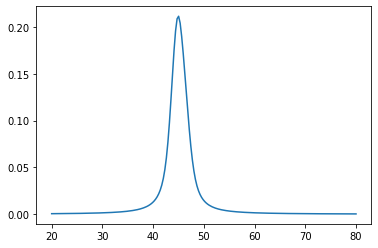

In [75]:
y6 = np.linspace(20, 80, 200)
# Calcula la likelihood para cada sample de la posterior y para cada valor de y6
A = cauchy(loc=theta_samples[np.newaxis, :]).pdf(y6[:, np.newaxis])
# Promedia a lo largo del eje correspondiente.
plt.plot(y6, A.mean(axis=1))

Y sampleamos, tal como hicimos antes

In [76]:
y_samples=np.random.choice(y6, p=A.mean(axis=1)/np.sum(A.mean(axis=1)), size=1000)

Text(0.5, 0, '$y_{6}$')

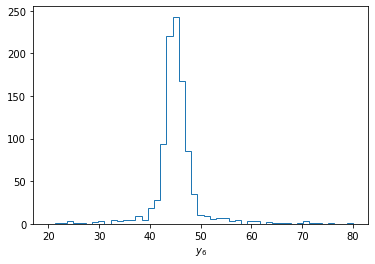

In [77]:
plt.hist(y_samples,bins=bins,histtype='step')
#plt.plot(y6, A.mean(axis=1))
plt.xlabel(r'$y_{6}$')

Luego Gelman nos sugiere que aprovechemos todavia más el sampleo de la posterior.

Dado los N $\theta_{n} \sim p(\theta|y)$: 

* Si sampleamos $y_{n} \sim p(y|\theta_{n})$, tenemos N sampleos de la conjunta $p(y_{6}, \theta|y_{1},...,y_{5})$.
* Si despues marginalizamos sobre $\theta$, vamos a tener datos que siguen $p(y_{6}|y_{1},...,y_{5})$.

> Nico: no me queda claro qué significa lo de recién...
>
> Más abajo grafican el resultado como "MCMC sampling" (markov chain monte carlo?)

¿Como marginalizamos?

Una manera es haciendo histogramas en $y$ con todos los valores de $\theta$.

In [78]:
# rvs = "random variates"
y_samples_bis=np.asarray([cauchy(loc=theta).rvs() for theta in theta_samples])
y_samples_bis.shape

(1000,)

Text(0.5, 0, '$y_{6}$')

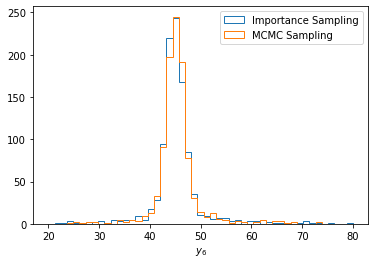

In [79]:
#bins=100
bins=np.linspace(20, 80, 50)
plt.hist(y_samples,    bins=bins,histtype='step',label='Importance Sampling')
plt.hist(y_samples_bis,bins=bins,histtype='step',label='MCMC Sampling')
#plt.plot(y6, A.mean(axis=1))
plt.legend(loc='upper right')
plt.xlabel(r'$y_{6}$')

En lo importante, dan muy parecidos los metodos. Sin embargo...

In [82]:
print(min(y_samples),max(y_samples))
print(min(y_samples_bis),max(y_samples_bis))

22.110552763819094 79.69849246231155
-4452.3299147009 931.9235884310406


## Punto extra: cambiar el prior

Jueguen con otros priors, por ejemplo:

* ¿Qué pasa si tenemos un prior uniforme entre [0, 20]?
* ¿Y si nuestro prior es $\mathcal{N}(50,1^{2})$?